In [1]:
%load_ext autoreload
%autoreload 2
%load_ext lab_black

import numpy as np
import pandas as pd
from glob import glob
import os
import statsmodels.api as sm
from typing import List
import itertools
import matplotlib.pyplot as plt
from scipy import stats
import calpgs
from sklearn.model_selection import train_test_split
import seaborn as sns
from plot_utils import lighten_boxplot
from tqdm import tqdm
import admix

plt.rcParams["font.family"] = "Arial"

# Model
We have genetic component $g$, environment component $e$, two covariates (one continuous, mimicking age, and one binary, mimicking sex) $c_1, c_2$ and their corresponding effects $\alpha_1, \alpha_2$. The phenotype is defined as $y = g + e + c_1 \alpha_1 + c_2 \alpha_2$. 

We assume that some PRS is derived $\hat{g}$, and it is assumed that $E[\hat{g} - g] = 0$. But for some reason, $\hat{g} \sim \mathcal{N}(g, \tau_0 + \tau_1 c_1 + \tau_2 c_2)$. Therefore, some differntial performance between $\hat{g}$ and $g$ across groups of individuals.


In [2]:
df_cov = pd.read_csv("data/cov.tsv", sep="\t", index_col=0).reset_index(drop=True)
n_indiv = df_cov.shape[0]
df_cov["GIA"] = np.sort(stats.expon.ppf(np.linspace(0.01, 0.4, n_indiv)))[
    stats.rankdata(df_cov["PC1"], method="ordinal") - 1
]
# df_cov["GIA"] = df_cov["GIA"]
df_cov.drop(columns="PC1", inplace=True)
df_cov = df_cov.sample(frac=0.2, replace=False)

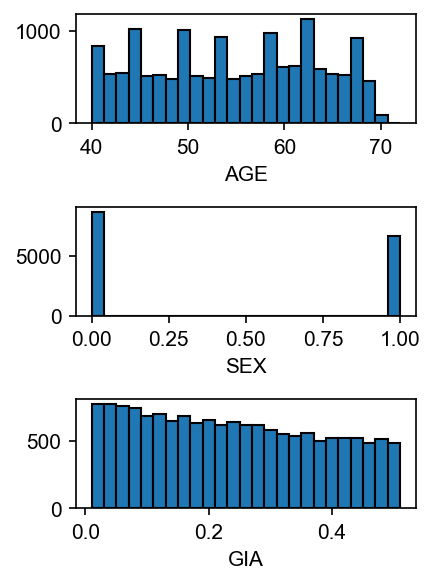

In [5]:
fig, axes = plt.subplots(figsize=(3, 4), nrows=df_cov.shape[1], dpi=150)
for i, col in enumerate(df_cov.columns):
    axes[i].hist(
        df_cov[col],
        bins=25,
        linewidth=1,
        edgecolor="black",
    )
    axes[i].set_xlabel(col)
fig.tight_layout()

In [6]:
def simulate_data(
    n_indiv: float, baseline_r2: float, cov: np.ndarray, cov_effects: np.ndarray
):
    """
    Simulate phenotype, PRS, with the noise level as a function of covariates

    Parameters
    ----------
    n_indiv: int
        number of individuals
    baseline_r2: float
        R2 of PRS
    cov: np.ndarray
        covariates matrix
    cov_effects: np.ndarray
        1d vector covariate effects
    """
    assert n_indiv == cov.shape[0]
    if not isinstance(cov_effects, np.ndarray):
        cov_effects = np.array(cov_effects)
    assert cov.shape[0] == n_indiv
    assert cov.shape[1] == len(cov_effects)
    pred = np.random.normal(size=n_indiv)
    noise_var = cov @ cov_effects
    tau0 = 1 / baseline_r2 - 1
    y = pred + np.random.normal(scale=np.sqrt(tau0 + noise_var), size=n_indiv)
    return pred, y

In [7]:
print(df_cov.columns)

Index(['AGE', 'SEX', 'GIA'], dtype='object')


In [8]:
cov = df_cov.values.copy()
cov = (cov - cov.mean(axis=0)) / cov.std(axis=0)
# age, sex, GIA
cov_effects = [0.2, 0.2, 0.2]
n_indiv = cov.shape[0]

In [9]:
np.random.seed(1234)

pred, y = simulate_data(
    n_indiv=n_indiv, baseline_r2=0.5, cov=cov, cov_effects=cov_effects
)
df_trait = pd.concat(
    [pd.DataFrame({"pred": pred, "y": y}, index=df_cov.index), df_cov], axis=1
)
# add dummy variable
for i in range(50):
    df_trait[f"DUMMY{i}"] = np.random.normal(size=len(df_trait))

Text(0, 0.5, '$y$')

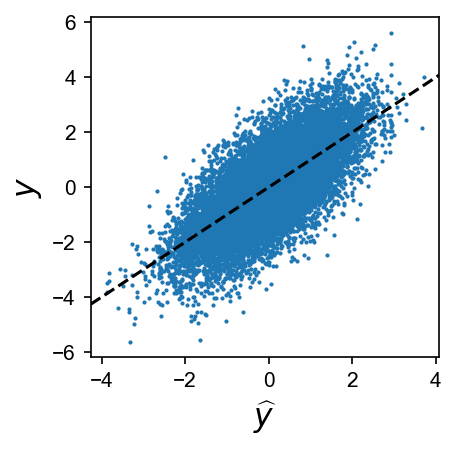

In [10]:
fig, ax = plt.subplots(figsize=(3, 3), dpi=150)
ax.scatter(pred, y, s=1)
ax.axline((0, 0), slope=1, ls="--", color="black", zorder=10)
ax.set_xlabel("$\widehat{y}$", fontsize=15)
ax.set_ylabel("$y$", fontsize=15)

In [11]:
df_trait["AGE_q"] = pd.qcut(df_trait["AGE"], q=5).cat.codes
df_trait["GIA_q"] = pd.qcut(df_trait["GIA"], q=5).cat.codes
df_trait["predstd0"] = 1.0

Bootstrapping: 100%|██████████| 100/100 [00:00<00:00, 144.89it/s]


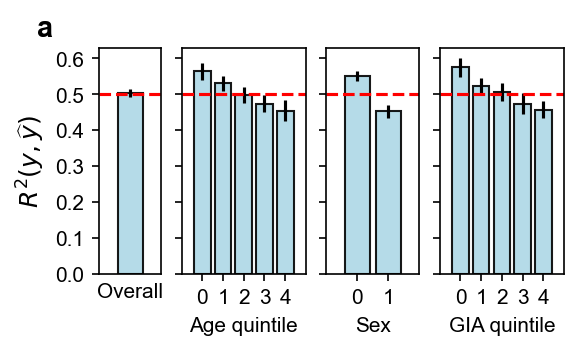

In [12]:
fig, axes = plt.subplots(
    figsize=(4, 2),
    dpi=150,
    ncols=4,
    sharey=True,
    gridspec_kw={"width_ratios": [1, 2, 1.5, 2]},
)

dict_cov_label = {
    None: "Overall",
    "AGE_q": "Age quintile",
    "GIA_q": "GIA quintile",
    "SEX": "Sex",
}
for i, cov in enumerate(
    [
        None,
        "AGE_q",
        "SEX",
        "GIA_q",
    ]
):
    df_res, df_res_se = calpgs.summarize_pred(
        df_trait, y_col="y", pred_col="pred", group_col=cov, n_bootstrap=100
    )
    r2, r2_se = df_res["r2"], df_res_se["r2"]
    if isinstance(r2, float):
        r2 = np.array([r2])
        r2_se = np.array([r2_se])
    else:
        r2 = r2.values
        r2_se = r2_se.values
    axes[i].bar(
        x=np.arange(len(r2)),
        height=r2,
        yerr=r2_se * 2,
        edgecolor="k",
        linewidth=1,
        alpha=0.9,
        color="lightblue",
    )
    axes[i].set_xlim(-1, len(r2))

    if cov is None:
        axes[i].set_xticks([])
    else:
        axes[i].set_xticks(np.arange(len(r2)))
    axes[i].set_xlabel(dict_cov_label[cov])
    axes[i].axhline(y=0.5, ls="--", color="red")
axes[0].set_yticks([0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6])
axes[0].set_ylabel("$R^2 (y, \widehat{y})$", fontsize=12)
axes[0].text(
    -1,
    1.05,
    "a",
    transform=axes[0].transAxes,
    size=14,
    weight="bold",
)
plt.savefig("results/r2.pdf", bbox_inches="tight")

Apply different methods and evaluate calibration here.

In [13]:
print(f"{len(df_trait)} individuals in total")

15273 individuals in total


In [18]:
def evaluate(df_cal, df_test, adjust_cols):
    # by default, adjust_cols = ["AGE", "SEX", "GIA"]
    dict_res0 = {}
    dict_res1 = {}
    for group_col in [None, "AGE_q", "GIA_q", "SEX"]:
        df_cov0 = calpgs.summarize_pred(
            df_test,
            y_col="y",
            pred_col="pred",
            predstd_col="predstd0",
            group_col=group_col,
        )["coverage"]
        if group_col is None:
            dict_res0["marginal"] = df_cov0
        else:
            dict_res0[group_col] = df_cov0.iloc[-1]

    if adjust_cols is None:
        train_ci_adjust_vars = test_ci_adjust_vars = None
    else:
        train_ci_adjust_vars = df_cal[adjust_cols]
        test_ci_adjust_vars = df_test[adjust_cols]
    # train calibration model
    model = calpgs.calibrate_model(
        y=df_cal["y"].values,
        pred=df_cal["pred"].values,
        predstd=df_cal["predstd0"].values,
        ci_method="scale",
        ci_adjust_vars=train_ci_adjust_vars,
    )

    # adjust
    df_test["cal_pred"], df_test["cal_predstd"] = calpgs.calibrate_adjust(
        model=model,
        pred=df_test["pred"].values,
        predstd=df_test["predstd0"].values,
        ci_adjust_vars=test_ci_adjust_vars,
    )

    # evaluate
    for group_col in [None, "AGE_q", "GIA_q", "SEX"]:
        df_cov1 = calpgs.summarize_pred(
            df_test,
            y_col="y",
            pred_col="pred",
            predstd_col="cal_predstd",
            group_col=group_col,
        )["coverage"]
        if group_col is None:
            dict_res1["marginal"] = df_cov1
        else:
            dict_res1[group_col] = df_cov1.iloc[-1]
    return pd.Series(dict_res0), pd.Series(dict_res1)

# Compute all data

In [19]:
dict_df_plot = dict()

for adjust in tqdm(["all", "none"]):
    #     "except-age", "dummy5", "dummy25", "dummy50", ]):
    if adjust == "all":
        adjust_cols = ["AGE", "SEX", "GIA"]
    elif adjust == "except-age":
        adjust_cols = ["SEX", "GIA"]
    elif adjust.startswith("dummy"):
        n_dummy = int(adjust.lstrip("dummy"))
        adjust_cols = ["AGE", "SEX", "GIA"] + [f"DUMMY{i}" for i in range(n_dummy)]
    elif adjust == "none":
        adjust_cols = None
    else:
        raise NotImplementedError
    dict_df_cov0 = dict()
    dict_df_cov1 = dict()
    for n_calibrate in [100, 500, 2500, 5000]:
        df_cov0 = []
        df_cov1 = []
        for seed in range(30):
            # divide the data
            df_cal, df_test = train_test_split(
                df_trait, test_size=5000, random_state=seed
            )
            df_cal = df_cal.iloc[0:n_calibrate, :].copy()
            df_test = df_test.copy()
            df0, df1 = evaluate(df_cal, df_test, adjust_cols=adjust_cols)
            df_cov0.append(df0)
            df_cov1.append(df1)
        dict_df_cov0[n_calibrate] = pd.concat(df_cov0, axis=1).T
        dict_df_cov1[n_calibrate] = pd.concat(df_cov1, axis=1).T

    df_plot = {"n": [], "col": [], "coverage": []}

    for n in dict_df_cov1:
        for col in [
            "marginal",
            "SEX",
            "GIA_q",
            "AGE_q",
        ]:
            covs = dict_df_cov1[n][col].values
            df_plot["n"].extend([n] * len(covs))
            df_plot["col"].extend([col] * len(covs))
            df_plot["coverage"].extend(covs)
    df_plot = pd.DataFrame(df_plot)
    dict_df_plot[adjust] = df_plot

  0%|          | 0/2 [00:00<?, ?it/s]/Users/kangchenghou/anaconda3/lib/python3.8/site-packages/statsmodels/regression/quantile_regression.py:191: IterationLimitWarning: Maximum number of iterations (1000) reached.
  warnings.warn("Maximum number of iterations (" + str(max_iter) +
/Users/kangchenghou/anaconda3/lib/python3.8/site-packages/statsmodels/regression/quantile_regression.py:191: IterationLimitWarning: Maximum number of iterations (1000) reached.
  warnings.warn("Maximum number of iterations (" + str(max_iter) +
/Users/kangchenghou/anaconda3/lib/python3.8/site-packages/statsmodels/regression/quantile_regression.py:191: IterationLimitWarning: Maximum number of iterations (1000) reached.
  warnings.warn("Maximum number of iterations (" + str(max_iter) +
100%|██████████| 2/2 [00:22<00:00, 11.09s/it]


In [20]:
dict_df_plot.keys()

dict_keys(['all', 'none'])

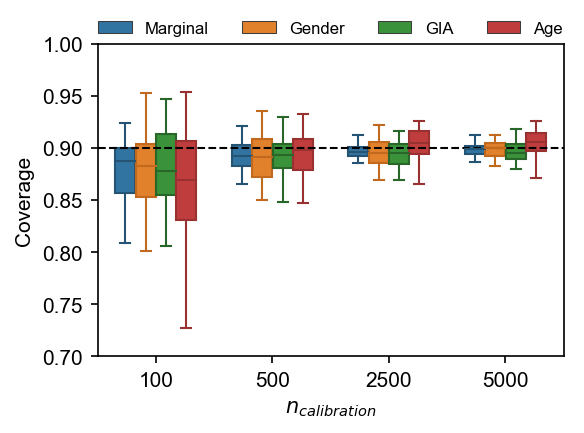

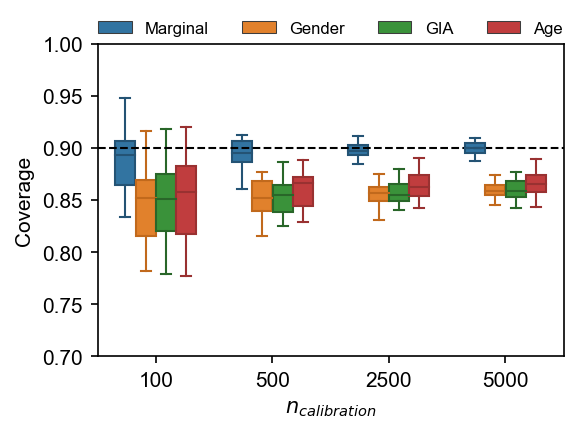

In [21]:
for adjust in dict_df_plot:
    df_plot = dict_df_plot[adjust]

    fig, ax = plt.subplots(figsize=(4, 3), dpi=150)

    sns.boxplot(
        x="n",
        y="coverage",
        hue="col",
        width=0.7,
        linewidth=1.0,
        fliersize=0,
        data=df_plot,
        ax=ax,
    )

    ax.axhline(y=0.9, color="black", lw=1.0, ls="--")
    ax.set_xlabel("$n_{calibration}$")
    ax.set_ylabel("Coverage")

    lighten_boxplot(ax)
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(
        handles=handles,
        labels=[
            "Marginal",
            "Gender",
            "GIA",
            "Age",
        ],
        title=None,
        ncol=4,
        loc="center",
        bbox_to_anchor=(0.5, 1.05),
        fontsize=8,
        frameon=False,
    )
    ax.set_ylim(0.7, 1.0)
    plt.tight_layout()
    plt.savefig(f"results/coverage_{adjust}.pdf", bbox_inches="tight")